In [55]:
#Importing read-sm-files.py
import ReadSMFIles
from Resource import Resource
from Task import Task
from Schedule import Schedule
import random
from typing import List, Tuple, Callable
import numpy as np
import matplotlib.pyplot as plt

#reading j30.sm/j301_1.sm file
sm_file = ReadSMFIles.SMFileParser.parse_sm_file("j30.sm/j301_1.sm")

print(sm_file)


(   renewable  nonrenewable  doubly_constrained
0          4             0                   0, {'pronr': 1, 'jobs': 30, 'rel_date': 0, 'duedate': 38, 'tardcost': 26, 'MPM_Time': 38},     jobnr  modes  successors_count    successors
0       1      1                 3     [2, 3, 4]
1       2      1                 3   [6, 11, 15]
2       3      1                 3    [7, 8, 13]
3       4      1                 3    [5, 9, 10]
4       5      1                 1          [20]
5       6      1                 1          [30]
6       7      1                 1          [27]
7       8      1                 3  [12, 19, 27]
8       9      1                 1          [14]
9      10      1                 2      [16, 25]
10     11      1                 2      [20, 26]
11     12      1                 1          [14]
12     13      1                 2      [17, 18]
13     14      1                 1          [17]
14     15      1                 1          [25]
15     16      1                

In [56]:
#Creating resources
r1 = int(sm_file[4].R1[0])
r2 = int(sm_file[4].R2[0])
r3 = int(sm_file[4].R3[0])
r4 = int(sm_file[4].R4[0])

R1 = Resource('R1', r1)
R2 = Resource('R2', r2)
R3 = Resource('R3', r3)
R4 = Resource('R4', r4)

resources = [R1, R2, R3, R4]

print([resource.name for resource in resources], [resource.per_period_availability for resource in resources])


['R1', 'R2', 'R3', 'R4'] [12, 13, 4, 12]


In [57]:
#Creating jobs
jobs_enumerate = sm_file[3].jobnr
jobs_duration = sm_file[3].duration
jobs_resources = sm_file[3].resources
jobs_successors = sm_file[2].successors

jobs = [None for _ in jobs_enumerate]


for i in jobs_enumerate:
    jobs[i - 1] = Task(str(i), jobs_duration[i - 1])

for i in range(len(resources)):
    for j in range(len(jobs)):
        jobs[j].add_renewable_resource(resources[i], jobs_resources[j][i])

for i in range(len(jobs)):
    successors = jobs_successors[i]
    for j in successors:
        jobs[i].add_sucessor(jobs[j - 1])
    


# jobs = jobs[1:-1]

for job in jobs:
    print(job.name, [sucessor.name for sucessor in job.predecessors])

    

    



1 []
2 ['1']
3 ['1']
4 ['1']
5 ['4']
6 ['2']
7 ['3']
8 ['3']
9 ['4']
10 ['4']
11 ['2']
12 ['8']
13 ['3']
14 ['9', '12']
15 ['2']
16 ['10']
17 ['13', '14']
18 ['13']
19 ['8']
20 ['5', '11', '18']
21 ['16']
22 ['16', '17', '18']
23 ['20', '22']
24 ['19', '23']
25 ['10', '15', '20']
26 ['11']
27 ['7', '8']
28 ['21', '27']
29 ['19']
30 ['6', '24', '25']
31 ['26', '28']
32 ['29', '30', '31']



Genetic Algorithm



In [58]:
#Genetic Algorithm

#Creating random population
def create_population(population_size, jobs, resources: List[Resource]):
    population = []
    for i in range(population_size):
        schedule = Schedule()
        schedule.add_renewable_resources(resources)
        copy = jobs.copy()
        random.shuffle(copy)
        schedule.add_tasks(copy)
        population.append(schedule)
    
    return population

def create_population_with_valid_individuals(population_size: int, jobs: List[Task], resources: List[Resource]) -> List[Schedule]:
    population = []
    for _ in range(population_size):
        schedule = Schedule()
        schedule.add_renewable_resources(resources)
        _jobs = jobs.copy()
        while len(_jobs) > 0:
            job = random.choice(_jobs)
            schedule.add_task(job)
            if schedule.is_valid_precedence_relations_constraint():
                _jobs.remove(job)
            else:
                schedule.remove_task(job)
        population.append(schedule)
    return population


population = create_population(10, jobs, resources)
# population = create_population_with_valid_individuals(1, jobs, resources)
print('----------------------------------------------------------------------------------------------------')
for individual in population:
    print([task.name for task in individual.tasks], individual.makespan(), individual.is_valid_precedence_relations_constraint(), individual.count_precedence_relations_violations())


----------------------------------------------------------------------------------------------------
['Dummy Source', '29', '24', '15', '20', '1', '17', '26', '5', '32', '25', '8', '12', '11', '27', '9', '3', '13', '4', '16', '14', '21', '22', '23', '19', '7', '18', '6', '2', '31', '10', '28', '30', 'Dummy Sink'] 525 False 22
['Dummy Source', '17', '20', '32', '10', '22', '25', '18', '29', '24', '31', '7', '21', '23', '2', '9', '4', '14', '16', '19', '6', '5', '12', '8', '15', '26', '28', '1', '13', '27', '11', '3', '30', 'Dummy Sink'] 942 False 30
['Dummy Source', '28', '12', '9', '17', '24', '15', '6', '27', '7', '25', '19', '26', '22', '32', '21', '18', '23', '8', '5', '11', '16', '30', '1', '10', '13', '14', '29', '4', '3', '31', '2', '20', 'Dummy Sink'] 1024 False 31
['Dummy Source', '3', '30', '7', '12', '1', '23', '16', '20', '22', '5', '2', '10', '32', '28', '29', '18', '26', '15', '17', '27', '19', '13', '6', '9', '4', '25', '24', '31', '8', '21', '11', '14', 'Dummy Sink'] 798

Crossover

In [59]:

class OnePointCrossoverOperator:
    def __init__(self, crossover_rate: float = 0.8):
        self.crossover_rate = crossover_rate

    def __call__(
            self, parent1: Schedule, parent2: Schedule
    ) -> Tuple[Schedule, Schedule]:
        if random.random() > self.crossover_rate:
            return parent1, parent2
        n = len(parent1.tasks)
        crossover_point = random.randint(1, n - 3)

        child1 = Schedule()
        child2 = Schedule()

        parent1_tasks = parent1.tasks.copy()[1:-1]
        parent2_tasks = parent2.tasks.copy()[1:-1]

        child1.add_tasks(parent1_tasks[:crossover_point])
        for task in parent2.tasks:
            if task not in child1.tasks and task.name != 'Dummy Source' and task.name != 'Dummy Sink':
                child1.add_task(task)
        
        child2.add_tasks(parent2_tasks[:crossover_point])
        for task in parent1.tasks:
            if task not in child2.tasks and task.name != 'Dummy Source' and task.name != 'Dummy Sink':
                child2.add_task(task)

        return child1, child2


crossover = OnePointCrossoverOperator()

offspring = []
for i in range(0, len(population)):
    parent1 = random.choice(population)
    parent2 = random.choice(population)
    child1, child2 = crossover(parent1, parent2)
    offspring.append(child1)


#PRINTING TIME INTERVALS
for task in child1.tasks:
    print(task.earliest_start, task.earliest_finish, task.duration)




0 0 0
13 15 2
13 21 8
52 54 2
47 50 3
35 37 2
0 6 6
6 9 3
17 20 3
21 27 6
15 21 6
0 4 4
17 24 7
4 9 5
12 21 9
47 50 3
27 35 8
12 21 9
55 55 0
0 0 0
50 52 2
11 14 3
45 47 2
9 11 2
4 12 8
45 52 7
17 24 7
6 13 7
35 40 5
40 47 7
4 13 9
14 17 3
35 45 10
55 55 0


Parent Selection

In [60]:
class TournamentSelector:
    def __init__(self, tournament_size: int = 3):
        self.tournament_size = tournament_size

    def __call__(self, population: List[Schedule], fitness: List[int] = []) -> List[Schedule]:
        sample_indexes = random.sample(range(len(population)), self.tournament_size)
        sample_fitness = [fitness[i] for i in sample_indexes]
        min_fit_index = sample_indexes[
            sample_fitness.index(min(sample_fitness))
        ]
        return population[min_fit_index]

selector = TournamentSelector(tournament_size=3)

selected = selector(population, [individual.makespan() for individual in population])

print(selected.is_valid_precedence_relations_constraint(), selected.tasks, selected.makespan())

False [<Task.Task object at 0x7f86788398d0> <Task.Task object at 0x7f86787d3010>
 <Task.Task object at 0x7f86787bb040> <Task.Task object at 0x7f86787bbeb0>
 <Task.Task object at 0x7f86789d57e0> <Task.Task object at 0x7f86787b99c0>
 <Task.Task object at 0x7f86787e9b40> <Task.Task object at 0x7f86787e9480>
 <Task.Task object at 0x7f86789d58d0> <Task.Task object at 0x7f86787baef0>
 <Task.Task object at 0x7f86789d0e80> <Task.Task object at 0x7f86787e95d0>
 <Task.Task object at 0x7f86789d38e0> <Task.Task object at 0x7f86787eb0a0>
 <Task.Task object at 0x7f86787b9720> <Task.Task object at 0x7f86789d43d0>
 <Task.Task object at 0x7f86787eaf50> <Task.Task object at 0x7f86791acfd0>
 <Task.Task object at 0x7f86789d59f0> <Task.Task object at 0x7f86789d54e0>
 <Task.Task object at 0x7f86789d3fd0> <Task.Task object at 0x7f86787eb2b0>
 <Task.Task object at 0x7f86787ea860> <Task.Task object at 0x7f86789d3880>
 <Task.Task object at 0x7f86787bbf10> <Task.Task object at 0x7f86787e9090>
 <Task.Task object 

In [61]:
class SwapMutationOperator:
    def __init__(self, mutation_rate: float = 0.2):
        self.mutation_rate = mutation_rate

    def __call__(self, individual: Schedule) -> Schedule:
        if random.random() > self.mutation_rate:
            return individual

        n = len(individual.tasks)
        i, j = random.sample(range(1, n - 1), 2)
        individual.tasks[i], individual.tasks[j] = individual.tasks[j], individual.tasks[i]
        return individual

print([task.name for task in population[0].tasks], individual.makespan())
mutator = SwapMutationOperator()
population2 = population.copy()
individual = population2[0]
mutated_individual = mutator(individual)

print([task.name for task in mutated_individual.tasks], mutated_individual.makespan())

['Dummy Source', '29', '24', '15', '20', '1', '17', '26', '5', '32', '25', '8', '12', '11', '27', '9', '3', '13', '4', '16', '14', '21', '22', '23', '19', '7', '18', '6', '2', '31', '10', '28', '30', 'Dummy Sink'] 788
['Dummy Source', '29', '24', '15', '20', '1', '17', '26', '5', '32', '25', '8', '12', '11', '27', '9', '3', '13', '4', '16', '14', '21', '22', '23', '19', '7', '18', '6', '2', '31', '10', '28', '30', 'Dummy Sink'] 536


Next Generation Producer

In [62]:
class NextGenerationProducer:
    def __init__(
        self,
        selector: Callable[[np.ndarray, np.ndarray], np.ndarray],
        crossover_op: Callable[[np.ndarray, np.ndarray], np.ndarray],
        mutator: Callable[[np.ndarray], np.ndarray],
        best_individual_mutator: Callable[[np.ndarray], np.ndarray] | None = None,
        preserve_best: bool = True,
        mutate_best: bool = True,
    ) -> None:
        self.selector = selector
        self.crossover_op = crossover_op
        self.mutator = mutator
        self.preserve_best = preserve_best
        self.mutate_best = mutate_best

        if best_individual_mutator is None:
            self.best_individual_mutator = mutator
        else:
            self.best_individual_mutator = best_individual_mutator

    def __call__(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> np.ndarray:
        target_size = len(population)
        if self.preserve_best:
            target_size -= 1
        if self.mutate_best:
            target_size -= 1

        next_gen = np.zeros_like(population)
        for i in range(0, target_size, 2):
            # Select two parents
            parent1 = self.selector(population, fitness)
            parent2 = self.selector(population, fitness)

            # Combine parents to generate new individual
            new_ind = self.crossover_op(parent1, parent2)

            # Mutate new individual and add it to the next generation
            mutated_new_ind = self.mutator(new_ind[0]), self.mutator(new_ind[1])

            # Add new individual to the population
            next_gen[i] = mutated_new_ind[0]
            next_gen[i + 1] = mutated_new_ind[1]

        if self.preserve_best or self.mutate_best:
            best_fitness_index = np.argmin(fitness)
            best_individual = population[best_fitness_index]

            ind = -1

            if self.preserve_best:
                next_gen[ind] = best_individual
                ind -= 1

            if self.mutate_best:
                next_gen[ind] = self.best_individual_mutator(best_individual)

        return next_gen

nextGenProducer = NextGenerationProducer(
    TournamentSelector(tournament_size=3), 
    OnePointCrossoverOperator(crossover_rate=0.8), 
    SwapMutationOperator(mutation_rate=0.2),
    SwapMutationOperator(mutation_rate=0.2),
    True,
    True
)

# fitness = [individual.makespan() for individual in population]

# nextGen = nextGenProducer(population=population, fitness=fitness)

# for individual in nextGen:
#     print(individual.makespan(), [task.name for task in individual.tasks])



Genetic Algorithm

In [63]:
class GeneticAlgorithm:
    def __init__(
        self,
        next_gen_prod: NextGenerationProducer,
        *,
        opt_value: np.ndarray | None = None,
        max_generations: int = 1000,
        min_improvement_threshold: float = 1e-3,
        max_gens_without_min_improvement: int | None = 100,
        mean_improvement_threshold: float = 1e-3,
        max_gens_without_mean_improvement: int | None = 100,
        min_pop_diversity_std_dev: float | None = None,
        precision: float = 1e-6,
    ) -> None:
        self.next_gen_prod = next_gen_prod
        self.max_gens = max_generations
        self.opt_value = opt_value
        self.min_improvement_threshold = min_improvement_threshold
        self.max_gens_without_min_improvement = max_gens_without_min_improvement
        self.mean_improvement_threshold = mean_improvement_threshold
        self.max_gens_without_mean_improvement = max_gens_without_mean_improvement
        self.min_pop_diversity_std_dev = min_pop_diversity_std_dev
        self.precision = precision

        self.gen_fitness_history = []

    def _step(
        self, population: np.ndarray, fitness=np.ndarray
    ) -> tuple[np.ndarray, np.ndarray]:
        next_gen = self.next_gen_prod(population, fitness)
        next_gen_fitness = [individual.makespan() for individual in next_gen]

        return next_gen, next_gen_fitness

    def _compute_gen_fit_history(
        self, population: np.ndarray, fitness: np.ndarray
    ) -> None:
        self.gen_fitness_history.append(
            {
                "mean": np.mean(fitness),
                "min": np.min(fitness),
                "max": np.max(fitness),
                "std_dev": np.std(fitness),
                "best_individual": population[np.argmin(fitness)],
            }
        )

    def execute(
        self, initial_population: np.ndarray, verbosity: int = 0
    ) -> None:
        prev_gen = initial_population
        prev_gen_fitness = [individual.makespan() for individual in initial_population]

        self._compute_gen_fit_history(prev_gen, prev_gen_fitness)

        # Initialize data for the loop
        gens_without_mean_improvement = 0
        gens_without_min_improvement = 0
        best_mean = self.gen_fitness_history[-1]["mean"]
        best_min = self.gen_fitness_history[-1]["min"]
        self.gen_fitness_history.clear()

        for gen_index in range(self.max_gens):
            stop = False

            # Evolve population
            next_gen, next_gen_fitness = self._step(prev_gen, prev_gen_fitness)
            self._compute_gen_fit_history(next_gen, next_gen_fitness)
            # Check stop criteria
            # Optimal value found?
            if self.opt_value is not None:
                dist = np.min(np.linalg.norm(next_gen - self.opt_value,axis=1))
                if dist < self.precision:
                    if verbosity > 0:
                        best_individual = self.gen_fitness_history[-1]["best_individual"]
                        print(
                            f"Stopping at iteration {gen_index} because a individual ({best_individual}) close enough to the optimal value ({self.opt_value}) was found."
                        )
                    stop = True

            # Mean improvement
            if self.max_gens_without_mean_improvement is not None:
                if best_mean - self.gen_fitness_history[-1]["mean"] > self.mean_improvement_threshold:
                    best_mean = self.gen_fitness_history[-1]["mean"]
                    gens_without_mean_improvement = 0
                else:
                    gens_without_mean_improvement += 1

                if gens_without_mean_improvement > self.max_gens_without_mean_improvement:
                    if verbosity > 0:
                        print(
                            f"Stopping at iteration {gen_index} because too many iterations ({self.max_gens_without_mean_improvement}) were executed without providing a mean fitness improvement."
                        )
                    stop = True

            # Min improvement
            if self.max_gens_without_min_improvement is not None:
                if best_min - self.gen_fitness_history[-1]["min"] > self.min_improvement_threshold:
                    best_min = self.gen_fitness_history[-1]["min"]
                    gens_without_min_improvement = 0
                else:
                    gens_without_min_improvement += 1

                if gens_without_min_improvement > self.max_gens_without_min_improvement:
                    if verbosity > 0:
                        print(f"Stopping at iteration {gen_index} because too many iterations ({self.max_gens_without_min_improvement}) were executed without providing a minimal fitness improvement.")
                    stop = True

            # Population diversity smaller than limit?
            if self.min_pop_diversity_std_dev is not None:
                fit_std_dev = np.std(next_gen_fitness)
                if fit_std_dev < self.min_pop_diversity_std_dev:
                    if verbosity > 0:
                        print(
                            f"Stopping at iteration {gen_index} because population diversity ({fit_std_dev}) was smaller than the allowed minimum {self.min_pop_diversity_std_dev}."
                        )
                    stop = True

            # Update generation
            prev_gen = next_gen
            prev_gen_fitness = next_gen_fitness

            if verbosity > 1:
                print("Iteration", gen_index, ":", self.gen_fitness_history[-1])

            if stop:
                break

        return prev_gen[np.argmin(prev_gen_fitness)]

In [64]:
def plot_run_hist(gen_hist: list[dict]) -> None:
    fig, ax = plt.subplots()

    iterations = list(range(len(gen_hist)))
    # Average
    avg = [gen["mean"] for gen in gen_hist]
    ax.plot(iterations, avg, label="Average")

    # Max
    _max = [gen["max"] for gen in gen_hist]
    ax.plot(iterations, _max, label="Maximum")

    # Min
    _min = [gen["min"] for gen in gen_hist]
    ax.plot(iterations, _min, label="Minimum")

    ax.grid(True)
    # ax.set_yscale("log")
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness")
    ax.set_title("Minimum, Average and Maximum Fitness Across Generations")
    ax.legend(draggable=True)

Iteration 0 : {'mean': 134.5, 'min': 38, 'max': 453, 'std_dev': 125.1884579344278, 'best_individual': <Schedule.Schedule object at 0x7f8678a3b580>}
Iteration 1 : {'mean': 40.6, 'min': 38, 'max': 56, 'std_dev': 4.487761134463375, 'best_individual': <Schedule.Schedule object at 0x7f8678830370>}
Iteration 2 : {'mean': 46.35, 'min': 38, 'max': 74, 'std_dev': 13.741451888355902, 'best_individual': <Schedule.Schedule object at 0x7f86789c3c10>}
Iteration 3 : {'mean': 39.05, 'min': 38, 'max': 47, 'std_dev': 2.3124662159694354, 'best_individual': <Schedule.Schedule object at 0x7f86789c37f0>}
Iteration 4 : {'mean': 40.2, 'min': 38, 'max': 63, 'std_dev': 6.273754856543249, 'best_individual': <Schedule.Schedule object at 0x7f86789c3640>}
Iteration 5 : {'mean': 40.25, 'min': 38, 'max': 54, 'std_dev': 5.0386009963084, 'best_individual': <Schedule.Schedule object at 0x7f86789c0c70>}
Iteration 6 : {'mean': 43.5, 'min': 38, 'max': 54, 'std_dev': 7.172865536171719, 'best_individual': <Schedule.Schedule 

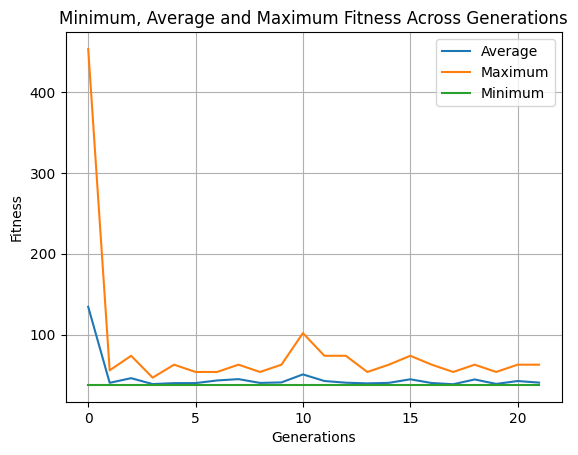

In [65]:
pop_size = 20
use_elitism = True
crossover_rate = 0.8
mutation_rate = 0.3
use_elitism = True
mutate_best = True
max_generations = 50
max_gens_without_min_improvement=20

initial_pop = create_population_with_valid_individuals(pop_size, jobs, resources)
# initial_pop = create_population(pop_size,jobs, resources)
# initial_pop.extend(some_valid_individuals)
initial_pop_fitness = [individual.makespan() for individual in initial_pop]

tournament_ga = GeneticAlgorithm(
    NextGenerationProducer(
        TournamentSelector(tournament_size=5),
        OnePointCrossoverOperator(crossover_rate=crossover_rate),
        SwapMutationOperator(mutation_rate=mutation_rate),
        SwapMutationOperator(mutation_rate=mutation_rate),
        preserve_best=use_elitism,
        mutate_best=mutate_best
    ),
    opt_value=None,
    max_generations=max_generations,
    max_gens_without_min_improvement=max_gens_without_min_improvement,
    max_gens_without_mean_improvement=None,
    min_pop_diversity_std_dev=None,
    precision=1e-6,
)

best_individual = tournament_ga.execute(initial_pop, 2)

print("Best Individual:", best_individual)
print("Fitness:", best_individual.makespan(), best_individual.is_valid_precedence_relations_constraint())
print("Violations:", best_individual.count_precedence_relations_violations())
print("Real Fitness:", best_individual.makespan_without_penalization())

plot_run_hist(tournament_ga.gen_fitness_history)